# Public Key Cryptography II

## 1 Elliptic curve over real numbers $\mathbb{R}$

Given the elliptic curve $E\ :\ y^2 =x^3−3x+9$. If this curve is not singular (check this), compute $a$ and $b$, such that $P_1 = (0,a)$ and $P_2 = (2,b)$ lay on $E$. Compute $P = P_1 +P_2$ and draw $E$ together with $P_1$ , $P_2$ and $P$.

## 2 Elliptic curve over real numbers $\mathbb{R}$

Given the elliptic curve $E\ :\ y^2 = x^3 −3x+5$ and point $P = (2,2.65)\in E$.


__Your Task__: Draw $E$, point $P$ and compute $2P$, $4P$ and $8P$. Solve this problem with minimal computational work!

## 3 Singular elliptic curve

Show that the condition $4a^3 +27b^2 \neq 0 \mod p$ is satisfied for the elliptic curve

$$y^2 \equiv x^3 +2x+7 \mod 17$$

For this elliptic curve, the two coefficients are $a,b = 2, 7$, hence the condition is $4\cdot 2^3 + 27\cdot 7^2 \equiv 12 \mod 17$, which means our ECC is non-singular (has no cusps or intersections)

In [9]:
print((4*2**3 + 27 * 7**2)%17)

12


Example of a singular ECC

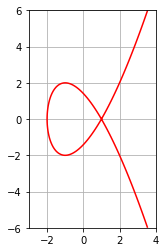

In [24]:
import numpy as np
import matplotlib.pyplot as plt

a = -3
b = 2
xlist = np.linspace( - 3, 4, 100)
ylist = np.linspace( - 6.0, 6.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = Y ** 2 - X ** 3 - a * X - b
plt.contour(X, Y, Z, [0], colors='red') 
plt.grid()
plt.axis('scaled')
plt.show()

## 4 Elliptic curve over finite field $\mathbb{Z}_7$

Let $E\ :\ y^2 \equiv x^3 +3x+2 \mod 7$ an elliptic curve over $\mathbb{Z}_7$.


__Your Task__:
1. Compute all points on $E$ over $\mathbb{Z}_7$.
2. What is the order of the group? (Hint: Do not miss the identity element $O$)
3. Given the element $\alpha = (0,3)$, determine the order of $\alpha$. Is $\alpha$ a primitive element?

## 5 Diffie-Hellman using ECC
Alice and Bob agree to use the elliptic curve $E\ :\ y^2 = x^3 +x+1$ and point $P = (5,4) \in E$. Alice chooses her secret number $a = 5$, whereas Bob chooses $b = 7$.


__Your Task__: Describe the key agreement protocol step by step using the above assumptions about $a$ and $b$. What is the common secret key?

## 6 Elliptic Curve Discrete Logarithm Problem (ECDLP)
Assume Mallory intercepts the message $A = (10,6)$ from Alice to Bob and $B = (7,11)$ from Bob to Alice. He also knows the elliptic curve $E\ :\ y^2 \equiv x^3 +2x+2 \mod 17$, which forms a cyclic group of order 19, and point $P = (5,1)$.

__Your Task__: Suppose Mallory wants to know the common key. Describe his steps to find this key!

In [26]:
(5**3+10+2)%17

1

$P$ is therefore located on $E$.

Mallory now calculates the remainder group, with somethin akin to the square-and-multiply algorithm:
$$ 1P = P $$
$$ 2P = P + P $$
$$ 3P = 2P + P $$
$$ 4P = 2P + 2P $$
$$ 5P = 4P + P $$
$$ \vdots $$

In [8]:
def ecc_add(a, b, point_1, point_2):
    assert isinstance(point_1, tuple)
    assert isinstance(point_2, tuple)
    x1,y1 = point_1
    x2,y2 = point_2
    if (x1 == x2):
        if (y1 == -y2):
            return (0,0)
        if (y1 == y2 and y1 != 0):
            s = (3 * x1 ** 2 + a)/(2 * y1)
    else:
        s = (y2 - y1)/(x2 - x1)
    x3 = s ** 2 - x1 - x2
    y3 = s * (x1 - x3) - y1
    return (x3,y3)

def ecc_double(a, b, point):
    assert isinstance(point, tuple)
    return ecc_add(a, b, point, point)

# Test for y^2 = x^3 + 73 (a,b = 1,73), should result in (-3.5555555555, -5.29629629)
print(ecc_double(1,73,(2,9)))

(-3.478395061728395, -5.04338134430727)


And as we are computing in a remainder group we have to change our program as follows:

In [16]:
# Source: https://stackoverflow.com/questions/4798654/modular-multiplicative-inverse-function-in-python
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

def ecc_add(a, b, p, point_1, point_2):
    assert isinstance(point_1, tuple)
    assert isinstance(point_2, tuple)
    x1,y1 = point_1
    x2,y2 = point_2
    if (x1 == x2):
        if (y1 == -y2):
            return (0,0)
        if (y1 == y2 and y1 != 0):
            s = ((3 * x1 ** 2 + a) * modinv((2 * y1), p)) % p
    else:
        s = ((y2 - y1)* modinv((x2 - x1), p)) % p
    x3 = (s ** 2 - x1 - x2) % p
    y3 = (s * (x1 - x3) - y1) % p
    return (x3,y3)

def ecc_double(a, b, p, point):
    assert isinstance(point, tuple)
    return ecc_add(a, b, p, point, point)

# Test for y^2 = x^3 + x + 1 mod 5 (a,b = 1,1), and Generator (0,1) should result in (4,2)
print("Test should result in (4,2): " + str(ecc_double(1,1,5,(0,1))))

a,b,p = 2,2,17

P = (5,1)
P2 = ecc_double(a,b,p,P)
P3 = ecc_add(a,b,p,P2,P)
P4 = ecc_double(a,b,p,P2)
P5 = ecc_add(a,b,p,P4,P)
P6 = ecc_double(a,b,p,P3)
P7 = ecc_add(a,b,p,P6,P)
P8 = ecc_double(a,b,p,P4)
P9 = ecc_add(a,b,p,P8,P)
P10 = ecc_double(a,b,p,P5)
P11 = ecc_add(a,b,p,P10,P)
P12 = ecc_double(a,b,p,P6)
P13 = ecc_add(a,b,p,P12,P)
P14 = ecc_double(a,b,p,P7)
P15 = ecc_add(a,b,p,P14,P)
P16 = ecc_double(a,b,p,P8)
P17 = ecc_add(a,b,p,P16,P)
P18 = ecc_double(a,b,p,P9)
P19 = ecc_add(a,b,p,P8,P)
P20 = ecc_double(a,b,p,P10)
P21 = ecc_add(a,b,p,P20,P)

print("1*P: " + str(P))
print("2*P: " + str(P2))
print("3*P: " + str(P3))
print("4*P: " + str(P4))
print("5*P: " + str(P5))
print("6*P: " + str(P6))
print("7*P: " + str(P7))
print("8*P: " + str(P8))
print("9*P: " + str(P9))
print("10*P: " + str(P10))
print("11*P: " + str(P11))
print("12*P: " + str(P12))
print("13*P: " + str(P13))
print("14*P: " + str(P14))
print("15*P: " + str(P15))
print("16*P: " + str(P16))
print("17*P: " + str(P17))
print("18*P: " + str(P18))
print("19*P: " + str(P19))
print("20*P: " + str(P20))
print("21*P: " + str(P21))

Test should result in (4,2): (4, 2)


Exception: modular inverse does not exist